In [1]:
import warnings
from time import strftime


data_dir = "."
# base_model_id = "microsoft/BioGPT-Large"
base_model_id = "microsoft/biogpt"
time = strftime("%Y%m%d-%H%M%S")
output_model_id = f"Cytotoxicity-Nanoparticles_BioGPT_{time}"
random_state = 42
cache_dir = "model"
warnings.filterwarnings("ignore")

# Data Processing

In [2]:
from datasets import load_dataset, ClassLabel

dataset = load_dataset("csv", data_files={"train": f"{data_dir}/train.csv", "test": f"{data_dir}/test.csv"})

dataset = dataset.cast_column("Viable", ClassLabel(num_classes=2, names=[0, 1]))
train_val_set = dataset["train"].train_test_split(
    test_size=0.1, stratify_by_column="Viable", seed=random_state
)
dataset["train"] = train_val_set["train"]
dataset["val"] = train_val_set["test"]

dataset

DatasetDict({
    train: Dataset({
        features: ['ID', 'Material', 'Type', 'Shape', 'Coat/Functional Group', 'Synthesis_Method', 'Surface_Charge', 'Cell_Type', 'No_of_Cells (cells/well)', 'Human_Animal', 'Cell_Source', 'Cell_Tissue', 'Cell_Morphology', 'Cell_Age', 'Cell Line_Primary Cell', 'Time (hr)', 'Concentration (ug/ml)', 'Test', 'Test_Indicator', 'Size', 'Zeta', 'Viable', 'Viability'],
        num_rows: 1597
    })
    test: Dataset({
        features: ['ID', 'Material', 'Type', 'Shape', 'Coat/Functional Group', 'Synthesis_Method', 'Surface_Charge', 'Cell_Type', 'No_of_Cells (cells/well)', 'Human_Animal', 'Cell_Source', 'Cell_Tissue', 'Cell_Morphology', 'Cell_Age', 'Cell Line_Primary Cell', 'Time (hr)', 'Concentration (ug/ml)', 'Test', 'Test_Indicator', 'Size', 'Zeta', 'Viable', 'Viability'],
        num_rows: 762
    })
    val: Dataset({
        features: ['ID', 'Material', 'Type', 'Shape', 'Coat/Functional Group', 'Synthesis_Method', 'Surface_Charge', 'Cell_Type', 'No_of_

## Outliers Handling

Lower Bound: -0.8949999999999889, Upper Bound: 157.36899999999997


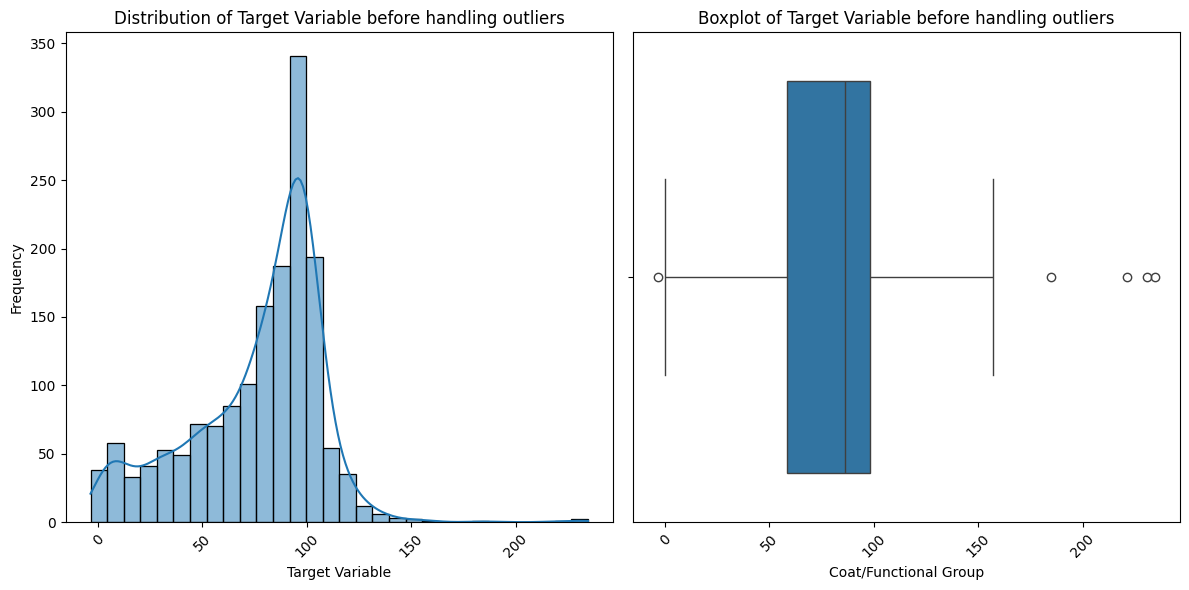

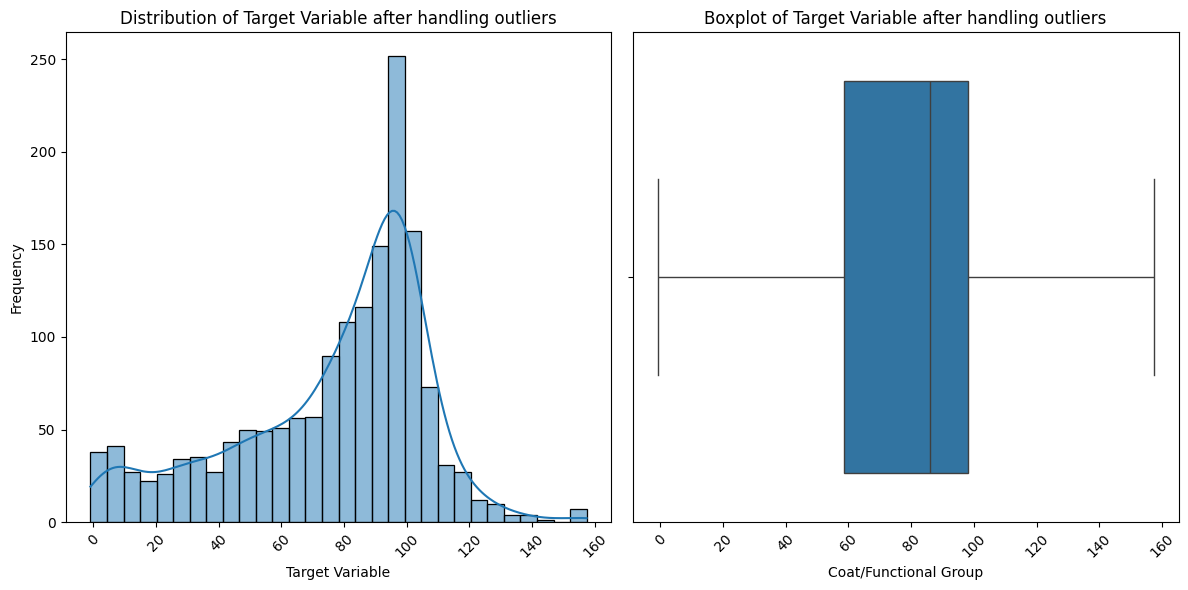

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt


def plot_distribution(y, subfix) -> None:

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)

    sns.histplot(y, kde=True, bins=30)
    plt.title(f"Distribution of Target Variable {subfix}")
    plt.xlabel("Target Variable")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)

    plt.subplot(1, 2, 2)
    sns.boxplot(x=y)
    plt.title(f"Boxplot of Target Variable {subfix}")
    plt.xlabel("Coat/Functional Group")
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()


train_df = dataset["train"].to_pandas()

Q1 = train_df["Viability"].quantile(0.25)
Q3 = train_df["Viability"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print(f"Lower Bound: {lower_bound}, Upper Bound: {upper_bound}")

plot_distribution(train_df["Viability"], "before handling outliers")
train_df["Viability"] = train_df["Viability"].clip(lower_bound, upper_bound)
dataset["train"] = dataset["train"].from_pandas(train_df)
plot_distribution(train_df["Viability"], "after handling outliers")

## Prompt Engineering

In [4]:
description = """The material of the nanoparticle is {material}. The nanoparticle is {type}. The morphology of the nanoparticle is {shape}. The fabrication method is {syn_method}. {coat}. The cell type is {cell_type}. The number of cells (cells/well) is {n_cell}. The origin species of the cell is {species}. The source of the cell line is {cell_source}. The type of cell tissue is {tissue}. The morphology of the cell is {cell_shape}. The cell is in {age} stage. The cell is {line_primary}. The exposure time is {time} hours. The exposure concentration is {conc} ug/ml. The type of cytotoxicity test is {test}. The test mechanism is {indicator}. The size of the nanoparticle is {size} nm. The zeta potential indicating surface charge stability of the nanoparticle is {zeta} mV"""

mapping = {
    "Human_Animal": {"H": "human", "A": "animal"},
    "Cell Line_Primary Cell": {"P": "primary", "L": "cell line"},
    "Type": {"I": "inorganic", "O": "organic", "C": "carbon"},
}


def get_coating(coat):
    if isinstance(coat, str):
        return "The surface coating is " + coat
    return "The cell has no surface coating"


def get_description(row) -> str:
    return description.format(
        material=row["Material"],
        type=mapping["Type"][row["Type"]],
        shape=row["Shape"].lower(),
        syn_method=row["Synthesis_Method"],
        coat=get_coating(row["Coat/Functional Group"]),
        cell_type=row["Cell_Type"],
        n_cell=row["No_of_Cells (cells/well)"],
        species=mapping["Human_Animal"][row["Human_Animal"]],
        cell_source=row["Cell_Source"],
        tissue=row["Cell_Tissue"].lower(),
        cell_shape=row["Cell_Morphology"],
        age=row["Cell_Age"].lower(),
        line_primary=mapping["Cell Line_Primary Cell"][row["Cell Line_Primary Cell"]],
        time=row["Time (hr)"],
        conc=row["Concentration (ug/ml)"],
        test=row["Test"],
        indicator=row["Test_Indicator"],
        size=row["Size"],
        zeta=row["Zeta"],
    )


reference = """Example {idx}:
- Description: {description}
- Answer: {viability}"""


def get_reference(idx, row) -> str:
    return reference.format(
        idx=idx,
        description=get_description(row),
        viability=row["Viability"],
    )


prompt = """Decide in a single word if the viability of a cell is high (>= 85%) or low (< 85%). {references}{description}. Viability (%):"""


def generate_prompt(batch: dict) -> dict:

    n = len(batch["ID"])
    examples = []
    for i in range(n):
        example = {k: batch[k][i] for k in batch.keys()}
        examples.append(example)

    if len(batch["ID"]) == 1:
        text = prompt.format(references="", description=get_description(examples[0]))
        return {
            "id": batch["ID"],
            "text": [text],
            "labels": batch["Viability"],
        }

    elif len(batch["ID"]) == 2:
        text = prompt.format(
            references=get_reference("", examples[1]),
            description=get_description(examples[1]),
        )
        return {
            "id": [examples[0]["ID"]],
            "text": [text],
            "labels": [examples[0]["Viability"]],
        }

    text = prompt.format(
        references="\n".join([get_reference(i, examples[i]) for i in range(n-1)]),
        description=get_description(examples[0]),
    )
    return {
        "id": [examples[0]["ID"]],
        "text": [text],
        "labels": [examples[0]["Viability"]],
    }


old_columns = dataset["train"].column_names
dataset["train"] = dataset["train"].map(
    generate_prompt,
    remove_columns=old_columns,
    batched=True,
    batch_size=1,
)
dataset["val"] = dataset["val"].map(
    generate_prompt,
    remove_columns=old_columns,
    batched=True,
    batch_size=1,
)
dataset["test"] = dataset["test"].map(
    generate_prompt,
    remove_columns=old_columns,
    batched=True,
    batch_size=1,
)

print("Train example " + "-" * 20)
print(f"{dataset['train'][0]['text']} {dataset['train'][0]['labels']}")
print("Val example " + "-" * 20)
print(f"{dataset['val'][0]['text']} {dataset['val'][0]['labels']}")
print("Test example " + "-" * 20)
print(f"{dataset['test'][0]['text']} {dataset['test'][0]['labels']}")

dataset

Map: 100%|██████████| 1597/1597 [00:00<00:00, 3938.95 examples/s]

Train example --------------------
Decide in a single word if the viability of a cell is high (>= 85%) or low (< 85%). The material of the nanoparticle is C60. The nanoparticle is carbon. The morphology of the nanoparticle is sphere. The fabrication method is Commercial. The surface coating is Dextran. The cell type is C6. The number of cells (cells/well) is 10000.0. The origin species of the cell is animal. The source of the cell line is Rat. The type of cell tissue is brain. The morphology of the cell is Fibroblast. The cell is in adult stage. The cell is cell line. The exposure time is 24 hours. The exposure concentration is 20.0 ug/ml. The type of cytotoxicity test is MTT. The test mechanism is TetrazoliumSalt. The size of the nanoparticle is 30.29 nm. The zeta potential indicating surface charge stability of the nanoparticle is -10.1 mV. Viability (%): 76.967
Val example --------------------
Decide in a single word if the viability of a cell is high (>= 85%) or low (< 85%). The ma

DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'labels'],
        num_rows: 1597
    })
    test: Dataset({
        features: ['id', 'text', 'labels'],
        num_rows: 762
    })
    val: Dataset({
        features: ['id', 'text', 'labels'],
        num_rows: 178
    })
})

## Tokenization

In [ ]:
from transformers import AutoTokenizer


def tokenize(examples):
    return tokenizer(examples["text"], padding=True, return_tensors='pt')


tokenizer = AutoTokenizer.from_pretrained(base_model_id, cache_dir=cache_dir)
tokenizer.push_to_hub(output_model_id)

dataset = dataset.map(tokenize, batched=True)
dataset

Map: 100%|██████████| 1597/1597 [00:03<00:00, 421.95 examples/s]


DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 1597
    })
    test: Dataset({
        features: ['id', 'text', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 762
    })
    val: Dataset({
        features: ['id', 'text', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 178
    })
})

# Model Training

## Model Loading

In [6]:
from transformers import AutoModelForSequenceClassification


id2label = {0: "HIGH"}
label2id = {"HIGH": 0}

model = AutoModelForSequenceClassification.from_pretrained(
    base_model_id, 
    torch_dtype="auto",
    num_labels=1,
    id2label=id2label,
    label2id=label2id,
    cache_dir=cache_dir,
    attn_implementation="sdpa",
)

Some weights of BioGptForSequenceClassification were not initialized from the model checkpoint at microsoft/biogpt and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Metrics Defining

In [7]:
import numpy as np
import evaluate


mcc = evaluate.load("matthews_correlation")
r2 = evaluate.load("r_squared")
acc = evaluate.load("accuracy")


def compute_metrics(eval_pred):
    logits, labels_reg = eval_pred
    preds_reg = np.squeeze(logits)
    labels_cla = np.where(labels_reg >= 85, 1, 0)
    preds_cla = np.where(preds_reg >= 85, 1, 0)

    metrics = {"r_squared": r2.compute(predictions=preds_reg, references=labels_reg)}
    metrics.update(mcc.compute(predictions=preds_cla, references=labels_cla))
    metrics.update(acc.compute(predictions=preds_cla, references=labels_cla))

    return metrics

## Model Fine-tuning

In [8]:
from transformers import TrainingArguments, Trainer


training_args = TrainingArguments(
    output_dir=f"output/{output_model_id}",
    do_train=True,
    num_train_epochs=50,
    warmup_ratio=0.1,
    do_eval=True,
    per_device_train_batch_size=30,
    per_device_eval_batch_size=30,
    learning_rate=1e-4,
    weight_decay=1,
    eval_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    seed=random_state,
    save_total_limit=5,
    push_to_hub=True,
    hub_model_id=output_model_id,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["val"],
    compute_metrics=compute_metrics,
)

trainer.train()
trainer.push_to_hub()

Epoch,Training Loss,Validation Loss,R Squared,Matthews Correlation,Accuracy
1,3954.792000,1939.978271,-0.921000,0.000000,0.488764
2,1857.134500,1701.060181,-0.684000,0.000000,0.488764
3,1586.262000,1444.448486,-0.430000,0.000000,0.488764
4,1303.384300,1183.980713,-0.172000,0.000000,0.488764
5,1069.758000,936.996338,0.072000,0.000000,0.488764
6,852.725500,1015.570862,-0.005000,0.000000,0.488764
7,943.723200,853.459595,0.155000,0.000000,0.488764
8,768.215000,673.152466,0.334000,0.000000,0.488764
9,657.135300,646.288147,0.360000,0.000000,0.488764
10,610.825200,609.790100,0.396000,0.433174,0.713483


events.out.tfevents.1745778569.Turing.341813.0: 100%|██████████| 38.0k/38.0k [00:00<00:00, 92.4kB/s]


CommitInfo(commit_url='https://huggingface.co/tanthinhdt/Cytotoxicity-Nanoparticles_BioGPT_20250428-012904/commit/2727bab3f89fd6484da2664f805c132d1fb9dc76', commit_message='End of training', commit_description='', oid='2727bab3f89fd6484da2664f805c132d1fb9dc76', pr_url=None, repo_url=RepoUrl('https://huggingface.co/tanthinhdt/Cytotoxicity-Nanoparticles_BioGPT_20250428-012904', endpoint='https://huggingface.co', repo_type='model', repo_id='tanthinhdt/Cytotoxicity-Nanoparticles_BioGPT_20250428-012904'), pr_revision=None, pr_num=None)

## Model Evaluation

In [9]:
trainer.evaluate(dataset["train"])

{'eval_loss': 105.09187316894531,
 'eval_r_squared': 0.89,
 'eval_matthews_correlation': 0.8072222027988327,
 'eval_accuracy': 0.9035691922354414,
 'eval_runtime': 29.0597,
 'eval_samples_per_second': 54.956,
 'eval_steps_per_second': 1.858,
 'epoch': 50.0}

In [10]:
trainer.evaluate(dataset["val"])

{'eval_loss': 245.14837646484375,
 'eval_r_squared': 0.757,
 'eval_matthews_correlation': 0.7879209439770772,
 'eval_accuracy': 0.8932584269662921,
 'eval_runtime': 3.4004,
 'eval_samples_per_second': 52.346,
 'eval_steps_per_second': 1.764,
 'epoch': 50.0}

# Inference

In [11]:
import pandas as pd


ids = [row["id"] for row in dataset["test"].select_columns(["id"])]
outputs = trainer.predict(dataset["test"])
reg_preds = outputs.predictions.squeeze()
cla_preds = np.where(reg_preds >= 85, 1, 0)


submission_cla_df = pd.DataFrame({"ID": ids, "Target": cla_preds})
submission_cla_df.to_csv("submission_cla.csv", index=False)

submission_reg_df = pd.DataFrame({"ID": ids, "Target": reg_preds})
submission_reg_df.to_csv("submission_reg.csv", index=False)